# Skye and Drew's Excellent Adventure
## Predictive Maintenance of Hydraulic Pumps with Industrial Applications


![Hydraulic Machine](./images/NTT-Sept-17.png)
## Overview / Business Problem

The stakeholder is a hydroponic farming start-up called Square Roots. The start-up spends a considerable amount of time and resources to maintain/monitor their irrigation systems. Square Roots is seeking to future proof their irrigation systems by monitoring the operation of mechanical components through various sensor data. This project will provide Square Roots with recommendations regarding which sensors provide the best predictive data for understanding the maintenance condition of their hydraulic pumps. By implementing these recommendations, Square Roots will be able to efficiently recognize the characteristics that imply an issues and in-turn, troubleshoot before any faults take place.

This project utilizes a data set which includes sensor data from 17 separate sensors collected over 2205 60-second hydraulic pump cycles. The pump condition was recorded for each 60-second cycle. The data set include five different target variables – cooler condition, valve condition, internal pump leakage, hydraulic accumulator (hydraulic pressure), and stable flag (stable condition). Although dependent on the target variable being utilized, a false positive with this data set generally implies an issue with the pump was predicted when there was no issue. In turn, a false negative implies no issues with the pump were predicted when there was in fact an issue. With regards to our stakeholder, Square Roots, a false negative would be more detrimental. Given the multiple target variables and multiple classes within a majority of these variables, the modeling performed within this analysis focuses on optimizing accuracy, the weighted F-1 score, and ROC-AUC score.

## Data Understanding

First, we performed feature extraction to condense the time-series data into a usable set of features and then used statistical analysis tools XGBoost and K-Nearest Neighbors to train our predictive models.


Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

<p>
<a href="https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems#">**This data**</a> comes from a set of sensor measurements taken during 2205 sixty second cycles of a hydraulic pump testing rig. During the testing the pump's maintenance status was recorded. These various metrics of the test rigs physical condition will be the target variable for our tests. The sensor data will be the predictors.

The goal will be to use sensor data (such as temperature, tank pressure, vibration magnitude, etc.) to
predict the state of the hydraulic pump.

The data is split between sensors. Each sensor has a specific sample rate qhich cooresponds to the columns
in its table. So `TS1.txt` contains temprature readings from one sensor. Its sample rate was 1hz for
each 60 second pump cycle. Therefore, in the `TS1.txt` file there are 60 columns and 2205 rows of data.
 
### Structure of the Data
**The structure of the data is this:**
1. The rows represent 1 cycle of the hydraulic test rig.
2. The individual txt files are sensor readings, rows represent a cycle, each column is a reading
   from that specific sensor.
3. Readings from each table are given in hz, and each cycle lasted 60 seconds. So, a 1hz sensor
   provides a 60 column by 2205 row table.
4. "Profile.txt" contains a 5 column by 2205 row table with system states encoded in each column.

### Target Variables
**Now that we can see the structure** of our target variables a little more clearly lets take a
look at the `profile.txt` file in our dataset. 

I will pull it inot a primary DataFrame object, so that we can continue to work with it; adding 
predictor variables and iterating over a test pipeline to find the best combinations for prediction.

Setting this up just requires pulling in the five columns and assigning column names based on our
encoding keys from the above dictionary.

In [316]:
import numpy as np
import pandas as pd
from pandas.errors import ParserError
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pickle
from joblib import dump, load
from tabulate import tabulate
from typing import Union, BinaryIO
from joblib import load, dump
from glob import iglob
import os
from time import perf_counter


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (plot_confusion_matrix, accuracy_score, recall_score,
                             precision_score, f1_score, roc_auc_score, plot_roc_curve, 
                             confusion_matrix, roc_curve)

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

Each row represents one full cycle and each column represents one sample (in this case 1 second) of readings from the temperatue sensor. To create features from this data we will need to come up with methods for aggregating each row of the sensor data into a single column of data.

##### Raw Table (ex: TS1.txt)
| cycle  |1s |2s |3s |.. |60s|
| :---:  |---|---|---|---|---|
| first: | 0 | 1 | 2 |...|59 |
| second:| 0 | 1 | 2 |...|59 |
|   ...  |...|...|...|...|...|
| last:  | 0 | 1 | 2 |...|59 |


##### Taking the average of each row:
| test     |1s-60s | << |
| :---:    | :---: |:---|
| first:   | avg[0]| << |
| second:  | avg[1]| << |
|   ...    |  ...  | << |
| last:    |avg[-1]| << |

| test   |1s-20s    |21s-40s   |41s-60s   |  << |
| :---:  | :---:    | :---:    | :---:    | :---|
| first: |avg[0][0] |avg[0][1] |avg[0][2] |  << |
| second:|avg[1][0] |avg[1][1] |avg[1][2] |  << |
|   ...  |  ...     |  ...     |  ...     |  << |
| last:  |avg[-1][0]|avg[-1][1]|avg[-1][2]|  << |
 
* If we apply this "pattern" to `TS1.txt` we end up with one feature column: *the mean temperature reading
from the sensor for all cycles*. 
* Repeating this pattern for each table of **sensor data** creates a full feature set of mean readings for
all 17 sensors across each **2205 pump cycles**.

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [317]:
# Printing out our list of features
# open our dictionary with feature info
with open('./features/sensor_info.pkl', 'rb') as featr:
    features = pickle.load(featr)
table = []
for itm in glob.iglob("./data/*.txt"):
    id = os.path.basename(itm)
    id = id[:-4]
    if id in ["documentation", "description", "profile"]:
        continue
    table.append([id, features[id]['type'], features[id]['unit'], features[id]['samp_rate']])
print(tabulate(table, tablefmt="github", headers=["id", "feature", "unit", "sample rate"]))

| id   | feature            | unit    |   sample rate |
|------|--------------------|---------|---------------|
| SE   | efficiency_factor  | percent |             1 |
| PS1  | pressure           | bar     |           100 |
| TS4  | temperature        | Ã‚Â°C   |             1 |
| PS2  | pressure           | bar     |           100 |
| PS3  | pressure           | bar     |           100 |
| TS3  | temperature        | Ã‚Â°C   |             1 |
| VS1  | vibration          | mm/s    |             1 |
| TS2  | temperature        | Ã‚Â°C   |             1 |
| PS6  | pressure           | bar     |           100 |
| PS4  | pressure           | bar     |           100 |
| TS1  | temperature        | Ã‚Â°C   |             1 |
| PS5  | pressure           | bar     |           100 |
| CP   | cooling_power      | kW      |             1 |
| CE   | cooling_efficiency | percent |             1 |
| EPS1 | motor_power        | W       |           100 |
| FS1  | volume_flow        | l/min   |         

In [318]:
# here I am using the information saved in cond_encodings.pkl to 
# make save each of our target variables in separate pickles.
with open('./features/cond_encoding.pkl', 'rb') as encodings:
    target = pickle.load(encodings)
    target = [col_str.strip('/% ').rstrip() for col_str in target.keys()]
    target = [itm.split() for itm in target]
    for ind, itm in enumerate(target):
        while "/" in itm:
            itm.remove("/")
        target[ind] = "_".join(itm)

y_data = pd.read_csv('./data/profile.txt', sep="\t", header=None, names=target)
for col in y_data.columns:
    y_data[col].to_pickle(f"./target_variables/{col}.pkl")

## Modeling

As previously mentioned, the data set includes five target variables – cooler condition, valve condition, internal pump leakage, hydraulic accumulator (hydraulic pressure), and stable flag (stable condition). We determined that each of these target variables were vital to the stakeholder and will likely impact our final recommendation. As a result, several models were created. About two models were created for each target variable. Depending on the variable, utilized, certain features were utilized including simple averages of the 60-second cycle, the average change over the course of the cycle, the average and change every 20-seconds of the cycle, and standard deviation of both the full 60-second cycle and every 20-seconds. To begin, we will utilize a simple logistic regression model. Given the data and the stakeholder’s business problem, it will make most sense to run a grid search on several different model types to determine which produces the highest accuracy.

### Baseline Model

To begin, the baseline model ran a simple logistic regression and included all X-variables and utilized ‘Valve Condition’ as the target variable. Valve Condition, measured as a percentage, includes four classifications – 100 meaning the pump was functioning at optimal switching behavior, 90 meaning there was a small lag, 80 meaning there was a severe lag, and 73 meaning the pump was close to total failure.

In [319]:
feature_avg = pd.read_pickle('./features/cycle_mean.pkl')
feature_avg.head()

,CE,CP,EPS1,FS1,FS2,PS1,PS2,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,39.601350,1.862750,2538.929167,6.709815,10.304592,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,59.157183,35.621983,40.978767,38.471017,31.745250,0.576950
1,25.786433,1.255550,2531.498900,6.715315,10.403098,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,59.335617,36.676967,41.532767,38.978967,34.493867,0.565850
2,22.218233,1.113217,2519.928000,6.718522,10.366250,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,59.543150,37.880800,42.442450,39.631950,35.646150,0.576533
3,20.459817,1.062150,2511.541633,6.720565,10.302678,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,59.794900,38.879050,43.403983,40.403383,36.579467,0.569267
4,19.787017,1.070467,2503.449500,6.690308,10.237750,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,59.455267,39.803917,44.332750,41.310550,37.427900,0.577367


In [320]:
with open('./features/cond_encoding.pkl', 'rb') as file:
    encoding = pickle.load(file)

In [321]:
target_cols = list(encoding.keys())
df = pd.read_csv('./data/profile.txt', sep='\t', header = None, names = target_cols)
df.head()

,Cooler Condition / %,Valve Condition / %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [322]:
#Set the first model's X and y variables
#Here, we will include all of the columns in our feature averages data frame
base_model_X = pd.read_pickle("./features/cycle_mean.pkl")
base_model_y = pd.read_pickle("./target_variables/Valve_Condition.pkl")

In [323]:
# shuffle and split, stratify keeps target distribution same in train/test
base_model_X_train, base_model_X_test, base_model_y_train, base_model_y_test = train_test_split(base_model_X, 
                                                                                base_model_y, 
                                                                                test_size = 0.15, 
                                                                                random_state = 42)

base_model_steps = [('std_scaler', StandardScaler()),
        ('dec_tree', DecisionTreeClassifier(random_state = 42))]

base_model_pipeline = Pipeline(base_model_steps)


# Train the pipeline (tranformations & predictor)
base_model_pipeline.fit(base_model_X_train, base_model_y_train)

base_model_prediction = base_model_pipeline.predict(base_model_X_test)
print(base_model_prediction)


[ 90  80 100  80 100  80 100  90 100  80  80  73 100 100  73  73  80 100
 100 100  90  73 100  73  90  73  80  73  90 100  80  90 100  73 100  73
 100  73 100  90 100 100 100 100 100  90  73 100  80  80 100 100 100 100
 100  73 100 100 100 100  80  73 100 100 100 100  90  90 100 100  90  90
  80  90  90  73 100  80 100  90  73  80  90 100  90  73  90 100  73 100
 100  73  80  90  80 100 100  80  90  90 100  90 100 100  90  90 100  73
  90 100  90  80  90 100  73 100  90 100 100  90 100 100 100  90 100  73
 100  73 100  80 100  80 100  80 100 100 100 100  80 100  90 100 100 100
  90  90 100 100  80  73 100  73  73  90 100 100 100 100 100 100 100 100
  73 100  80 100 100  73  90 100  80 100  73  90  90  73 100  73 100 100
 100 100 100 100 100  90  73  80 100  73 100 100  80  80  73 100  73 100
  73 100  73  73 100  80 100 100  90  73  73  73  80 100  90 100  90 100
 100  80 100  90 100 100  80  90  73  73  80  80  73  80 100  73 100  80
  90 100 100 100 100 100 100 100  73 100 100  90 10

In [324]:
base_model_pipe_grid = {'dec_tree__criterion': ['gini', 'entropy'],
                   'dec_tree__max_depth': [2,4,6,8,10,12]}

base_model_gs_pipe = GridSearchCV(estimator = base_model_pipeline, 
                       param_grid = base_model_pipe_grid, scoring = 'precision_micro')

base_model_gs_pipe.fit(base_model_X_train, base_model_y_train);

In [325]:
base_model_gs_pipe.best_params_

{'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 12}

In [326]:
base_model_gs_pipe.score(base_model_X_test, base_model_y_test)

0.9486404833836858

In [327]:
list(zip(base_model_X_train.columns, 
         base_model_gs_pipe.best_estimator_.named_steps['dec_tree'].feature_importances_))

[('CE', 0.004082948557540575),
 ('CP', 0.0),
 ('EPS1', 0.0029809480600318196),
 ('FS1', 0.0),
 ('FS2', 0.005572283865779667),
 ('PS1', 0.23932466556688314),
 ('PS2', 0.4085048358808755),
 ('PS3', 0.0011942162732920176),
 ('PS4', 0.012805097334171808),
 ('PS5', 0.02859957433813187),
 ('PS6', 0.022647470732487653),
 ('SE', 0.20432690049129285),
 ('TS1', 0.025506917602116014),
 ('TS2', 0.02162796525729697),
 ('TS3', 0.010817651743963349),
 ('TS4', 0.004585935220652116),
 ('VS1', 0.007422589075484678)]

### Multiple Model Testing with Grid Search

As previously mentioned, we are going to perform a grid search on multiple models to determine the highest performing models. For now, we will utilize a simple average of the test cycles as the feature.  Once we’ve determined the top performing models, we can perform grid searches with these models and repeat the process for other combinations of target variables and features.

### First Model:
### Feature, Target Variable: Simple Average, Valve Condition

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [328]:
model1_lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LogisticRegression(random_state = 42))])

model1_dtree_pipe = Pipeline([('scaler', StandardScaler()),
                    ('dtree',DecisionTreeClassifier(random_state = 42))])

model1_rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('rf',RandomForestClassifier(random_state = 42))])

model1_knn_pipe = Pipeline([('scaler', StandardScaler()),
                    ('knn', KNeighborsClassifier())])

model1_svm_pipe = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC(random_state = 42))])

model1_xgb_pipe = Pipeline([('scaler', StandardScaler()),
                     ('xgb', XGBClassifier(random_state = 42))])

In [329]:
model1_param_range = [1, 2, 3, 4, 5, 6]
model1_param_range_fl = [1.0, 0.5, 0.1]
model1_n_estimators = [50, 100, 150]
model1_learning_rates = [.1, .2, .3]

model1_lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
                   'lr__C': model1_param_range_fl,
                   'lr__solver': ['liblinear']}]

model1_dtree_param_grid = [{'dtree__criterion': ['gini', 'entropy'],
                   'dtree__min_samples_leaf': model1_param_range,
                   'dtree__max_depth': model1_param_range,
                   'dtree__min_samples_split': model1_param_range[1:]}]

model1_rf_param_grid = [{'rf__min_samples_leaf': model1_param_range,
                   'rf__max_depth': model1_param_range,
                   'rf__min_samples_split': model1_param_range[1:]}]

model1_knn_param_grid = [{'knn__n_neighbors': model1_param_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

model1_svm_param_grid = [{'svm__kernel': ['linear', 'rbf'], 
                    'svm__C': model1_param_range}]

model1_xgb_param_grid = [{'xgb__learning_rate': model1_learning_rates,
                    'xgb__max_depth': model1_param_range,
                    'xgb__min_child_weight': model1_param_range[:2],
                    'xgb__subsample': model1_param_range_fl,
                    'xgb__n_estimators': model1_n_estimators}]

In [330]:
model1_lr_grid_search = GridSearchCV(estimator = model1_lr_pipe,
                              param_grid = model1_lr_param_grid,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

model1_dtree_grid_search = GridSearchCV(estimator = model1_dtree_pipe,
                                 param_grid = model1_dtree_param_grid,
                                 scoring = 'accuracy',
                                 cv = 3,
                                 n_jobs = -1)

model1_rf_grid_search = GridSearchCV(estimator = model1_rf_pipe,
                              param_grid = model1_rf_param_grid,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

model1_knn_grid_search = GridSearchCV(estimator = model1_knn_pipe,
                               param_grid = model1_knn_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

model1_svm_grid_search = GridSearchCV(estimator = model1_svm_pipe,
                               param_grid = model1_svm_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

model1_xgb_grid_search = GridSearchCV(estimator = model1_xgb_pipe,
                               param_grid = model1_xgb_param_grid,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs = -1)

In [331]:
grids = [model1_lr_grid_search, 
         model1_dtree_grid_search, 
         model1_rf_grid_search, 
         model1_knn_grid_search, 
         model1_svm_grid_search, 
         model1_xgb_grid_search]

for i in grids:
    i.fit(base_model_X_train, base_model_y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [332]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}

for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],\
    model.score(base_model_X_test, base_model_y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
    print('\v')

Logistic Regression Test Accuracy: 0.8700906344410876
Logistic Regression Best Params: {'lr__C': 1.0, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Decision Trees Test Accuracy: 0.797583081570997
Decision Trees Best Params: {'dtree__criterion': 'gini', 'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 6}

Random Forest Test Accuracy: 0.8610271903323263
Random Forest Best Params: {'rf__max_depth': 6, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}

K-Nearest Neighbors Test Accuracy: 0.918429003021148
K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}

Support Vector Machines Test Accuracy: 0.9788519637462235
Support Vector Machines Best Params: {'svm__C': 6, 'svm__kernel': 'linear'}

XGBoost Test Accuracy: 0.972809667673716
XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}



In [333]:
list(zip(base_model_X_train.columns, 
         model1_xgb_grid_search.best_estimator_.named_steps['xgb'].feature_importances_))

[('CE', 0.039068956),
 ('CP', 0.029016161),
 ('EPS1', 0.042381942),
 ('FS1', 0.11295056),
 ('FS2', 0.039775964),
 ('PS1', 0.09620055),
 ('PS2', 0.11468861),
 ('PS3', 0.02678718),
 ('PS4', 0.046755668),
 ('PS5', 0.05789243),
 ('PS6', 0.076922685),
 ('SE', 0.16333772),
 ('TS1', 0.031819478),
 ('TS2', 0.033872727),
 ('TS3', 0.029593308),
 ('TS4', 0.021771073),
 ('VS1', 0.037164997)]

In [334]:
def create_confusion_matrix(grid_search, X_test, y_test):
    return plot_confusion_matrix(grid_search, 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues)
    plt.show

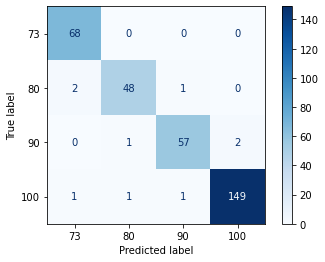

In [335]:
create_confusion_matrix(model1_xgb_grid_search, base_model_X_test, base_model_y_test)

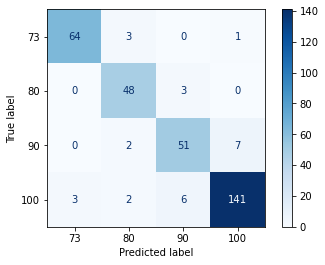

In [336]:
create_confusion_matrix(model1_knn_grid_search, base_model_X_test, base_model_y_test)

In [337]:
def get_f1_weighted_score(name, grid_search, X_test, y_test):
    test_preds = grid_search.predict(X_test)
    return print('{} F-1 Weighted Score: {}'.format(str(name), f1_score(y_test, test_preds, average = 'weighted')))


In [338]:
def get_roc_auc_score(name, gird_search, X_test, y_test):
    test_probas = gird_search.predict_proba(X_test)
    score = roc_auc_score(y_test, 
                          test_probas,
                          multi_class = 'ovo',
                          average = 'weighted')
    return print('{} ROC-AUC Score: {}'.format(str(name), score))

In [339]:
def get_accuracy(name, grid_search, X_test, y_test): 
    test_preds = grid_search.predict(X_test)
    return  print('{} Accuracy Score: {}'.format(str(name), accuracy_score(y_test, test_preds)))

In [340]:
get_accuracy('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test)
get_f1_weighted_score('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test)
get_roc_auc_score('KNN', model1_knn_grid_search, base_model_X_test, base_model_y_test)
print('\v')
get_accuracy('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test)
get_f1_weighted_score('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test)
get_roc_auc_score('XGB', model1_xgb_grid_search, base_model_X_test, base_model_y_test)

KNN Accuracy Score: 0.918429003021148
KNN F-1 Weighted Score: 0.9186346493473566
KNN ROC-AUC Score: 0.9432591283982722

XGB Accuracy Score: 0.972809667673716
XGB F-1 Weighted Score: 0.9727442972719881
XGB ROC-AUC Score: 0.9990739744776906


In [341]:
def true_pos_rate(grid_search, X_test, y_test):
    test_preds = grid_search.predict(X_test)
    true_pos_rate = recall_score(y_test, test_preds)
    return true_pos_rate

In [342]:
# confusion_matrix(model1_knn_grid_search.predict(base_model_X_test), base_model_y_test)

# metrics.roc_auc_score(model1_knn_pipe, base_model_X_test, base_model_y_test)

In [343]:
#Class 73
knn_class_73_fp = 3 + 0 + 1
knn_class_73_fn = 0 + 0 + 3
knn_class_73_tp = 64
knn_class_73_tn = 331 - knn_class_73_tp - knn_class_73_fn - knn_class_73_fp
knn_class_73_tpr = knn_class_73_tp / (knn_class_73_tp + knn_class_73_fn)
knn_class_73_fpr = knn_class_73_fp / (knn_class_73_fp + knn_class_73_tn)

#Class 80
knn_class_80_fp = 0 + 3 + 0
knn_class_80_fn = 3 + 2 + 2
knn_class_80_tp = 48
knn_class_80_tn = 331 - knn_class_80_tp - knn_class_80_fn - knn_class_80_fp
knn_class_80_tpr = knn_class_80_tp / (knn_class_80_tp + knn_class_80_fn)
knn_class_80_fpr = knn_class_80_fp / (knn_class_80_fp + knn_class_80_tn)


#Class 90
knn_class_90_fp = 0 + 2 + 7
knn_class_90_fn = 0 + 3 + 6
knn_class_90_tp = 51
knn_class_90_tn = 331 - knn_class_90_tp - knn_class_90_fn - knn_class_90_fp
knn_class_90_tpr = knn_class_90_tp / (knn_class_90_tp + knn_class_90_fn)
knn_class_90_fpr = knn_class_90_fp / (knn_class_90_fp + knn_class_90_tn)


#Class 100
knn_class_100_fp = 3 + 2 + 6
knn_class_100_fn = 1 + 0 + 7
knn_class_100_tp = 141
knn_class_100_tn = 331 - knn_class_100_tp - knn_class_100_fn - knn_class_100_fp
knn_class_100_tpr = knn_class_100_tp / (knn_class_100_tp + knn_class_100_fn)
knn_class_100_fpr = knn_class_100_fp / (knn_class_100_fp + knn_class_100_tn)

In [344]:
knn_class_80_fpr

0.010869565217391304

In [345]:
# from sklearn import datasets, metrics

# metrics.roc_auc_score(base_model_X_train, base_model_y_train)

0.06043956043956044


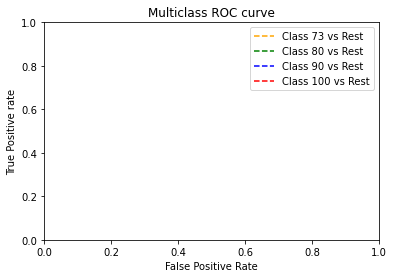

In [346]:
# plotting KNN ROC-AUC Curves

plt.plot(knn_class_73_fpr, 
         knn_class_73_tpr, 
         linestyle = '--', 
         color = 'orange', 
         label = 'Class 73 vs Rest')

plt.plot(knn_class_80_fpr, 
         knn_class_80_tpr,
         linestyle = '--',
         color = 'green', 
         label = 'Class 80 vs Rest')

plt.plot(knn_class_90_fpr, 
         knn_class_90_tpr,
         linestyle = '--',
         color = 'blue', 
         label = 'Class 90 vs Rest')

plt.plot(knn_class_100_fpr, 
         knn_class_100_tpr,
         linestyle = '--',
         color = 'red', 
         label = 'Class 100 vs Rest')
print(knn_class_100_fpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc = 'best')
plt.show()

# plt.savefig('Multiclass ROC', dpi = 300);

## Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

### Second Model:

### Feature, Target Variable: Simple Average, Internal Pump Leakage

### Grid Search Class / Function

In [347]:
class RegularModel:

    def __init__(self, X_path:Union[BinaryIO, str], y_path:Union[BinaryIO, str], X_name:str='', y_name:str='', random_state:int=42, test_size:float=0.15):
        self._X = pd.read_pickle(X_path)
        self._y = pd.read_pickle(y_path)
        self.features = X_name
        self.target = y_name
        self.rs = random_state
        self.test_size = test_size
        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(self._X, 
                                                                                        self._y, 
                                                                                        test_size = self.test_size, 
                                                                                        random_state = self.rs)

        _knn_pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsClassifier())])
        
        _xgb_pipe = Pipeline([('scaler', StandardScaler()),
                             ('xgb', XGBClassifier(random_state = self.rs))])

        param_range = [1, 2, 3, 4, 5, 6]
        param_range_fl = [1.0, 0.5, 0.1]
        n_estimators = [50, 100, 150]
        learning_rates = [.1, .2, .3]

        knn_param_grid = [{'knn__n_neighbors': param_range,
                           'knn__weights': ['uniform', 'distance'],
                           'knn__metric': ['euclidean', 'manhattan']}]

        xgb_param_grid = [{'xgb__learning_rate': learning_rates,
                            'xgb__max_depth': param_range,
                            'xgb__min_child_weight': param_range[:2],
                            'xgb__subsample': param_range_fl,
                            'xgb__n_estimators': n_estimators}]

        self.knn_grid_search = GridSearchCV(estimator = _knn_pipe,
                                       param_grid = knn_param_grid,
                                       scoring = 'accuracy',
                                       cv = 3,
                                       n_jobs = -1)

        self.xgb_grid_search = GridSearchCV(estimator = _xgb_pipe,
                                       param_grid = xgb_param_grid,
                                       scoring = 'accuracy',
                                       cv = 3,
                                       n_jobs = -1)
        
        self.grids = [self.knn_grid_search, self.xgb_grid_search]

    def fit_model(self):
        for i in self.grids:
            i.fit(self._X_train, self._y_train)
        return self
    
    def save_model(self, filename:Union[BinaryIO, str]):
        if not isinstance(joblib, Module):
            from joblib import dump
        dump(self, filename)

    def report(self, how:str="print", where:Union[BinaryIO, str]=""):
        grid_dict = {0: 'K-Nearest Neighbors', 1: 'XGBoost'}
        rep_list = []
        rep_list.append(f"Feature type: {self.features}\nTarget Variable: {self.target}\n")
        rep_list.append('\n')
        for i, model in enumerate(self.grids):
            rep_list.append('{} Test Accuracy: {}\n'.format(grid_dict[i],\
            model.score(self._X_test, self._y_test)))
            rep_list.append('{} Best Params: {}\n'.format(grid_dict[i], model.best_params_))
            rep_list.append('\n')
        if how == "file":
            if not where:
                raise ValueError("You must pass a string with filename and path to use 'file' output method.")
            with open(where, 'w') as file:
                file.writelines(rep_list)
                return print(f"Report ouput to {where}.")
        return print(*rep_list)

In [348]:
model2_X = "./features/cycle_mean.pkl"
model2_y = "./target_variables/Internal_pump_leakage.pkl"
model2 = RegularModel(model2_X, model2_y, 'Simple Averages', 'Internal Pump Leakage')
model2.fit_model()

Report ouput to ./test.txt.


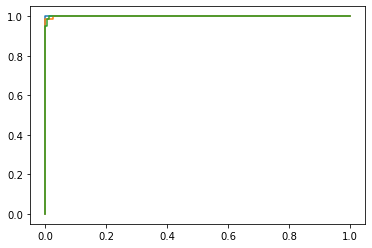

In [349]:
model2.report('file', './test.txt')
pred_prob2 = model2.xgb_grid_search.predict_proba(model2._X_test)
fpr1, tpr1, thresh0 = roc_curve(model2._y_test, pred_prob2[:,0], pos_label=0)
fpr2, tpr2, thresh1 = roc_curve(model2._y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(model2._y_test, pred_prob2[:,2], pos_label=2)
tpr2, fpr2
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.show()

In [350]:
model2.report()

Feature type: Simple Averages
Target Variable: Internal Pump Leakage
 
 K-Nearest Neighbors Test Accuracy: 0.9909365558912386
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 0.9879154078549849
 XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 100, 'xgb__subsample': 0.5}
 



In [351]:
get_accuracy('KNN', model2.grids[0], model2._X_test, model2._y_test)
get_f1_weighted_score('KNN', model2.grids[0], model2._X_test, model2._y_test)
get_roc_auc_score('KNN', model2.grids[0], model2._X_test, model2._y_test)
print('\v')
get_accuracy('XGB', model2.grids[1], model2._X_test, model2._y_test)
get_f1_weighted_score('XGB', model2.grids[1], model2._X_test, model2._y_test)
get_roc_auc_score('XGB', model2.grids[1], model2._X_test, model2._y_test)

KNN Accuracy Score: 0.9909365558912386
KNN F-1 Weighted Score: 0.9909369012573976
KNN ROC-AUC Score: 0.9919989085181639

XGB Accuracy Score: 0.9879154078549849
XGB F-1 Weighted Score: 0.9879154078549849
XGB ROC-AUC Score: 0.9997858907394336


In [352]:
list(zip(model2._X_train.columns, 
         model2.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

[('CE', 0.040790275),
 ('CP', 0.04286829),
 ('EPS1', 0.06284462),
 ('FS1', 0.2675513),
 ('FS2', 0.033654038),
 ('PS1', 0.038262468),
 ('PS2', 0.007846282),
 ('PS3', 0.012190825),
 ('PS4', 0.007991362),
 ('PS5', 0.014833858),
 ('PS6', 0.009381927),
 ('SE', 0.3590888),
 ('TS1', 0.012870789),
 ('TS2', 0.06422607),
 ('TS3', 0.01224936),
 ('TS4', 0.005392367),
 ('VS1', 0.0079574)]

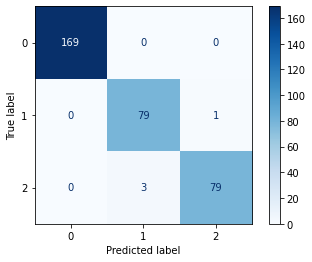

In [353]:
create_confusion_matrix(model2.grids[1], model2._X_test, model2._y_test)

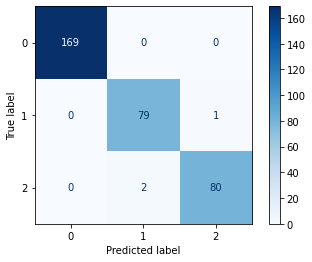

In [354]:
create_confusion_matrix(model2.grids[0], model2._X_test, model2._y_test)

### Second Model:
### Feature, Target Variable: Simple Average, Hydraulic Accumulator / Bar

In [355]:
model3_X = "./features/cycle_mean.pkl"
model3_y = "./target_variables/Hydraulic_accumulator_bar.pkl"
model3 = RegularModel(model3_X, model3_y, 'Simple Averages', 'Hydraulic Accumulator / Bar')
model3.fit_model()

In [356]:
model3.report()

Feature type: Simple Averages
Target Variable: Hydraulic Accumulator / Bar
 
 K-Nearest Neighbors Test Accuracy: 0.9637462235649547
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
 
 XGBoost Test Accuracy: 0.9697885196374623
 XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}
 



In [357]:
get_accuracy('KNN', model3.grids[0], model3._X_test, model3._y_test)
get_f1_weighted_score('KNN', model3.grids[0], model3._X_test, model3._y_test)
get_roc_auc_score('KNN', model3.grids[0], model3._X_test, model3._y_test)
print('\v')
get_accuracy('XGB', model3.grids[1], model3._X_test, model3._y_test)
get_f1_weighted_score('XGB', model3.grids[1], model3._X_test, model3._y_test)
get_roc_auc_score('XGB', model3.grids[1], model3._X_test, model3._y_test)

KNN Accuracy Score: 0.9637462235649547
KNN F-1 Weighted Score: 0.9635651973655772
KNN ROC-AUC Score: 0.9842895771996268

XGB Accuracy Score: 0.9697885196374623
XGB F-1 Weighted Score: 0.9698609457765859
XGB ROC-AUC Score: 0.9994806072890597


In [358]:
list(zip(model3._X_train.columns, 
         model3.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

[('CE', 0.07464489),
 ('CP', 0.046574567),
 ('EPS1', 0.059376642),
 ('FS1', 0.032784436),
 ('FS2', 0.09706607),
 ('PS1', 0.02076849),
 ('PS2', 0.02388537),
 ('PS3', 0.032448657),
 ('PS4', 0.030364523),
 ('PS5', 0.080152676),
 ('PS6', 0.0651364),
 ('SE', 0.10053402),
 ('TS1', 0.054618508),
 ('TS2', 0.054929644),
 ('TS3', 0.06911249),
 ('TS4', 0.1003717),
 ('VS1', 0.05723092)]

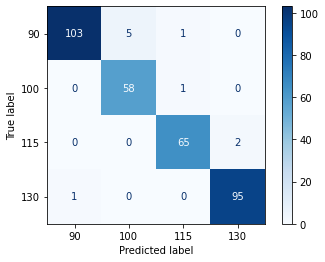

In [359]:
create_confusion_matrix(model3.grids[1], model3._X_test, model3._y_test)

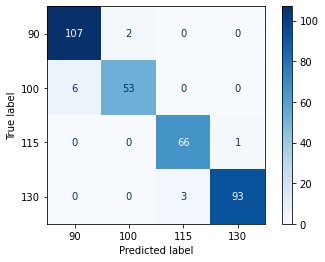

In [360]:
create_confusion_matrix(model3.grids[0], model3._X_test, model3._y_test)

### Feature, Target Variable: Simple Average, Stable Flag

In [361]:
model4_X = "./features/cycle_mean.pkl"
model4_y = "./target_variables/stable_flag.pkl"
model4 = RegularModel(model4_X, model4_y, 'Simple Averages', 'Stable Flag')
model4.fit_model()

In [362]:
model4.report()

Feature type: Simple Averages
Target Variable: Stable Flag
 
 K-Nearest Neighbors Test Accuracy: 0.9637462235649547
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 0.9667673716012085
 XGBoost Best Params: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 0.5}
 



In [363]:
get_accuracy('KNN', model4.grids[0], model4._X_test, model4._y_test)
get_f1_weighted_score('KNN', model4.grids[0], model4._X_test, model4._y_test)
# get_roc_auc_score('KNN', model4.grids[0], model4._X_test, model4._y_test)
print('\v')
get_accuracy('XGB', model4.grids[1], model4._X_test, model4._y_test)
get_f1_weighted_score('XGB', model4.grids[1], model4._X_test, model4._y_test)
# get_roc_auc_score('XGB', model4.grids[1], model4._X_test, model4._y_test)

KNN Accuracy Score: 0.9637462235649547
KNN F-1 Weighted Score: 0.9633435772317546

XGB Accuracy Score: 0.9667673716012085
XGB F-1 Weighted Score: 0.9663477541221549


In [364]:
list(zip(model4._X_train.columns, 
         model4.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

[('CE', 0.055520725),
 ('CP', 0.027705934),
 ('EPS1', 0.016901672),
 ('FS1', 0.07508104),
 ('FS2', 0.044801302),
 ('PS1', 0.101923294),
 ('PS2', 0.045497034),
 ('PS3', 0.01572853),
 ('PS4', 0.04360179),
 ('PS5', 0.18859589),
 ('PS6', 0.044532917),
 ('SE', 0.22230943),
 ('TS1', 0.022184258),
 ('TS2', 0.04064593),
 ('TS3', 0.022538431),
 ('TS4', 0.015656412),
 ('VS1', 0.016775357)]

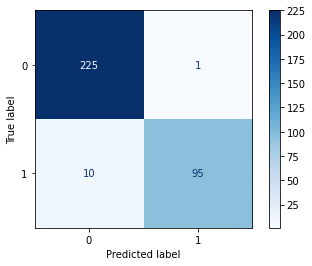

In [365]:
create_confusion_matrix(model4.grids[1], model4._X_test, model4._y_test)

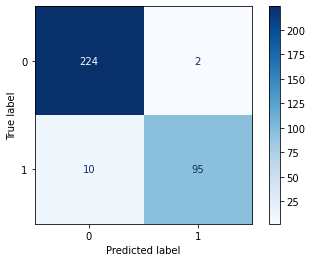

In [366]:
create_confusion_matrix(model4.grids[0], model4._X_test, model4._y_test)

### Feature, Target Variable: Simple Average, Cooler Condition / %

In [367]:
model5_X = "./features/cycle_mean.pkl"
model5_y = "./target_variables/Cooler_Condition.pkl"
model5 = RegularModel(model5_X, model5_y, 'Simple Averages', 'Cooler Condition / %')
model5.fit_model()

In [368]:
model5.report()

Feature type: Simple Averages
Target Variable: Cooler Condition / %
 
 K-Nearest Neighbors Test Accuracy: 1.0
 K-Nearest Neighbors Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 1.0
 XGBoost Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 1, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 1.0}
 



In [369]:
list(zip(model5._X_train.columns, 
         model5.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

[('CE', 0.5937464),
 ('CP', 0.19123779),
 ('EPS1', 0.0),
 ('FS1', 0.0),
 ('FS2', 2.8768736e-05),
 ('PS1', 0.0),
 ('PS2', 0.20224777),
 ('PS3', 2.3074144e-05),
 ('PS4', 0.006340876),
 ('PS5', 0.0),
 ('PS6', 0.0),
 ('SE', 0.00043923742),
 ('TS1', 0.0),
 ('TS2', 0.0),
 ('TS3', 0.0),
 ('TS4', 0.0059360685),
 ('VS1', 0.0)]

In [370]:
model6_df = pd.read_pickle(model5_X)

In [371]:
model6_df = model6_df.drop(['CE', 'FS2', 'PS5', 'PS6', 'CP', 'TS1', 'TS4', 'TS2'], axis = 1)
model6_df.to_pickle('./features/model6_dropped_columns.pkl')

In [372]:
model6_X = './features/model6_dropped_columns.pkl'
model6_y = './target_variables/Cooler_Condition.pkl'
model6 = RegularModel(model6_X, model6_y, 'Simple Averages', 'Cooler Condition / %')
model6.fit_model()

In [373]:
model6.report()

Feature type: Simple Averages
Target Variable: Cooler Condition / %
 
 K-Nearest Neighbors Test Accuracy: 0.9939577039274925
 K-Nearest Neighbors Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
 
 XGBoost Test Accuracy: 0.9969788519637462
 XGBoost Best Params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 2, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 150, 'xgb__subsample': 1.0}
 



In [374]:
list(zip(model6._X_train.columns, 
         model6.grids[1].best_estimator_.named_steps['xgb'].feature_importances_))

[('EPS1', 0.2313137),
 ('FS1', 0.0018095358),
 ('PS1', 0.0008786859),
 ('PS2', 0.115248896),
 ('PS3', 0.35238746),
 ('PS4', 0.028239887),
 ('SE', 0.0093286205),
 ('TS3', 0.2151588),
 ('VS1', 0.045634385)]

In [375]:
get_accuracy('KNN', model6.grids[0], model6._X_test, model6._y_test)
get_f1_weighted_score('KNN', model6.grids[0], model6._X_test, model6._y_test)
get_roc_auc_score('KNN', model6.grids[0], model6._X_test, model6._y_test)
print('\v')
get_accuracy('XGB', model6.grids[1], model6._X_test, model6._y_test)
get_f1_weighted_score('XGB', model6.grids[1], model6._X_test, model6._y_test)
get_roc_auc_score('XGB', model6.grids[1], model6._X_test, model6._y_test)

KNN Accuracy Score: 0.9939577039274925
KNN F-1 Weighted Score: 0.993964498113481
KNN ROC-AUC Score: 0.9957652283936271

XGB Accuracy Score: 0.9969788519637462
XGB F-1 Weighted Score: 0.9969809408583403
XGB ROC-AUC Score: 1.0


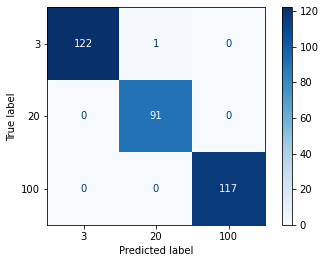

In [376]:
create_confusion_matrix(model6.grids[1], model6._X_test, model6._y_test)

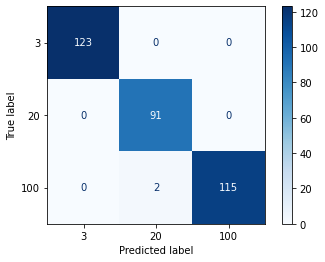

In [377]:
create_confusion_matrix(model6.grids[0], model6._X_test, model6._y_test)

## Modeling Other Features

In [378]:
## Average Thirds Models

In [379]:
# code here for your first 'substandard' model


In [380]:
# code here to iteratively improve your models


In [381]:
# creating a list of the feature and target sets saved to pickle files
features = [] 
for itm in iglob('./features/*.pkl'):
    filename = os.path.basename(itm)[:-4]
    if filename in ["cond_encoding", "sensor_info"]:
        continue
    features.append((filename, itm)) 
target_vars = [] 
for f_path in iglob("./target_variables/*.pkl"):
    filename = os.path.basename(f_path)[:-4]
    target_vars.append((filename, f_path))

In [382]:
# creating a list of arguments to pass to the model fit loop
args_list = []
for name, path in target_vars:
    for feature, pkl in features:
        args_list.append((pkl, path, feature, name))

In [383]:
def pool_func(args):
    start_t = perf_counter()
    _, _, feature, target = args
    model_inst = RegularModel(*args)
    model_inst.fit_model()
    dump(model_inst, f"./models/{target}_{feature}.pkl")
    log_loc = f"./models/{target}_{feature}.txt"
    model_inst.report("file", where=log_loc)
        
    end_t = perf_counter()
    return (f"Target variable {target} with feature set {feature}", end_t - start_t)

In [384]:
# for args in args_list:
#     msg, duration = pool_func(args)
#     print(f"{msg} took {duration} to compute.")

| Target     | Feature                   |   KNN Accuracry |   XGBoost Accuracy |
|   :---:    |          :---:            |      :---:      |        :---:       |
| avg_3rds   | Cooler_Condition          |        1        |           1        |
| avg_change | Cooler_Condition          |        0.924471 |           0.987915 |
| cycle_mean | Cooler_Condition          |        1        |           1        |
| dx_3rds    | Cooler_Condition          |        0.927492 |           0.996979 |
| std_3rds   | Cooler_Condition          |        0.996979 |           0.990937 |
| std_dev    | Cooler_Condition          |        0.990937 |           0.990937 |
| avg_3rds   | Hydraulic_accumulator_bar |        0.963746 |           0.987915 |
| avg_change | Hydraulic_accumulator_bar |        0.818731 |           0.963746 |
| cycle_mean | Hydraulic_accumulator_bar |        0.963746 |           0.969789 |
| dx_3rds    | Hydraulic_accumulator_bar |        0.670695 |           0.942598 |
| std_3rds   | Hydraulic_accumulator_bar |        0.930514 |           0.975831 |
| std_dev    | Hydraulic_accumulator_bar |        0.8429   |           0.915408 |
| avg_3rds   | Internal_pump_leakage     |        0.990937 |           0.996979 |
| avg_change | Internal_pump_leakage     |        0.697885 |           0.854985 |
| cycle_mean | Internal_pump_leakage     |        0.990937 |           0.987915 |
| dx_3rds    | Internal_pump_leakage     |        0.646526 |           0.794562 |
| std_3rds   | Internal_pump_leakage     |        0.92145  |           0.969789 |
| std_dev    | Internal_pump_leakage     |        0.963746 |           0.984894 |
| avg_3rds   | stable_flag               |        0.966767 |           0.963746 |
| avg_change | stable_flag               |        0.827795 |           0.942598 |
| cycle_mean | stable_flag               |        0.963746 |           0.966767 |
| dx_3rds    | stable_flag               |        0.800604 |           0.912387 |
| std_3rds   | stable_flag               |        0.957704 |           0.969789 |
| std_dev    | stable_flag               |        0.954683 |           0.969789 |
| avg_3rds   | Valve_Condition           |        0.984894 |           0.987915 |
| avg_change | Valve_Condition           |        0.465257 |           0.504532 |
| cycle_mean | Valve_Condition           |        0.918429 |           0.97281  |
| dx_3rds    | Valve_Condition           |        0.44713  |           0.483384 |
| std_3rds   | Valve_Condition           |        0.694864 |           0.933535 |
| std_dev    | Valve_Condition           |        0.752266 |           0.960725 |

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [385]:
# code here to show your final model

In [386]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
